# **Comparison between kappa.py and the Wong solver**

Default simulation parameters chosen for Pb-Pb at 5.02 TeV.

In [1]:
import numpy as np

# General parameters
su_group = 'su3'        # Gauge group
representation = 'fundamental'      # Fundamental or adjoint representation
boundary = 'bounded'        # Periodic boundary conditions or unbounded

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_s = 1.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.5      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 1    # Number of Glasma events
folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

p = {
    'FOLDER':   folder,         # results folder
    'MASS': mass,           # mass of HQ [GeV]
    'TFORM': tau_form,       # formation time of the HQ [fm/c]
    'PT': pT,           # transverse momentum of HQs [GeV]
    }

Set environment variables.

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group
os.environ["REPRESENTATION"] = representation
os.environ["BOUNDARY"] = boundary

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
from curraun.wong import init_charge
# Kappa module
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(3)
Using double precision
Using double precision


Simulation routine for solving Wong's equations.

In [3]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

def simulate(p, ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_s / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)

    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta
        angle = 2*np.pi*np.random.rand(1)
        p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    # ps = np.zeros((maxt-formt+1, ntp, 4))
    sigmapt_avg = np.zeros(maxt-formt)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                if t==formt:
                    pmu0 = wong_solver.p.copy()
                    px0, py0 = pmu0[:, 1], pmu0[:, 2]
                pmu = wong_solver.p.copy()
                # ps[t-formt] = pmu
                px, py = pmu[:, 1], pmu[:, 2]
                sigmapt = (px-px0)**2 + (py-py0)**2
                sigmapt_avg[t-formt] = np.mean(sigmapt) * E0**2

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = current_path + '/' + results_folder + '/' + wong_folder + '/'
    os.chdir(wong_path)

    output['sigmapt'] = sigmapt_avg
    # output['p'] = ps
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

Run over multiple Glasma events and perform averages.

In [4]:
quarks = ['static', 'charm', 'beauty']
pTs = [0.5, 5.0, 10.0]

sigmapt, tau = {}, {}
for quark in quarks:
    print('Quark', quark)
    if quark=='static':
        p['MASS'], p['TFORM'] = 200, 0
    if quark=='charm':
        p['MASS'], p['TFORM'] = 1.5, 0.06
    elif quark=='beauty':
        p['MASS'], p['TFORM'] = 4.5, 0.02

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quark + '_pT_' + str(pT)
        p['FOLDER'] = su_group + '_pT_' + str(pT) + '_' + quark 
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_s / L * N * DTS)
        taus = np.linspace(p['TFORM'], tau_s, maxt-formt)

        sigmapts = []
        for ev in range(nevents):
            output = simulate(p, ev)
            sigmapts.append(output['sigmapt'])

        sigmapt[tag] = np.mean(sigmapts, axis=0)
        tau[tag] = taus

output = {}
output['sigmapt'], output['tau'] = sigmapt, tau
filename = 'sigmapt.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Quark static
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 409/409 [02:18<00:00,  2.95it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 409/409 [02:13<00:00,  3.06it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 409/409 [02:13<00:00,  3.06it/s]


Quark charm
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 409/409 [02:10<00:00,  3.15it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 409/409 [02:09<00:00,  3.15it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 409/409 [02:09<00:00,  3.15it/s]


Quark beauty
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 409/409 [02:12<00:00,  3.09it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 409/409 [02:12<00:00,  3.09it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 409/409 [02:12<00:00,  3.09it/s]


Simulation routine for the static quark case.

In [4]:
os.chdir(current_path + '/' + results_folder)

def simulate_kappa(p, ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_s / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    kappa_tforce = kappa.TransportedForce(s)
    kappapt, tau =  [], []

    if use_cuda:
        s.copy_to_device()
        kappa_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t>=formt:  
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()

                    px_kappa, py_kappa = kappa_tforce.p_perp_mean[0], kappa_tforce.p_perp_mean[1]
                    kappapt.append((px_kappa + py_kappa) * E0 ** 2)
                    tau.append(t*a/DTS)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()

                kappa_tforce.compute()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    kappa_folder = p['FOLDER']
    if not os.path.isdir(kappa_folder):
        os.makedirs(kappa_folder)
    kappa_path = current_path + '/' + results_folder + '/' + kappa_folder + '/'
    os.chdir(kappa_path)

    output['kappapt'] = kappapt
    output['tau'] = tau
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

Run over multiple Glasma events and do averages.

In [6]:
nevents = 5
quarks = ['static', 'charm', 'beauty']

kappapt, tau = {}, {}
for quark in quarks:
    print('Quark', quark)
    if quark=='static':
        p['TFORM'] = 0
    if quark=='charm':
        p['TFORM'] = 0.06
    elif quark=='beauty':
        p['TFORM'] = 0.02

    tag = quark
    p['FOLDER'] = su_group + '_kappa_' + quark 

    kappapts = []
    for ev in range(nevents):
        output = simulate_kappa(p, ev)
        kappapts.append(output['kappapt'])
        tau[tag] = output['tau']

    kappapt[tag] = np.mean(kappapts, axis=0)

output = {}
output['kappapt'], output['tau'] = kappapt, tau
filename = 'kappapt.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Quark static


Event 5: 100%|██████████| 409/409 [00:05<00:00, 68.44it/s]


Quark charm


Event 5: 100%|██████████| 409/409 [00:05<00:00, 68.65it/s]


Quark beauty


Event 5: 100%|██████████| 409/409 [00:05<00:00, 68.47it/s]


Plot the results.

In [1]:
using Pickle

results = ["sigmapt", "kappapt"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "results/" * r * ".pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname(r,  data[r])
    string_as_varname("tau_" * r,  data["tau"])
end

quarks = ["charm", "beauty", "static"]
pTs = ["0.5", "5.0", "10.0"]

3-element Vector{String}:
 "0.5"
 "5.0"
 "10.0"

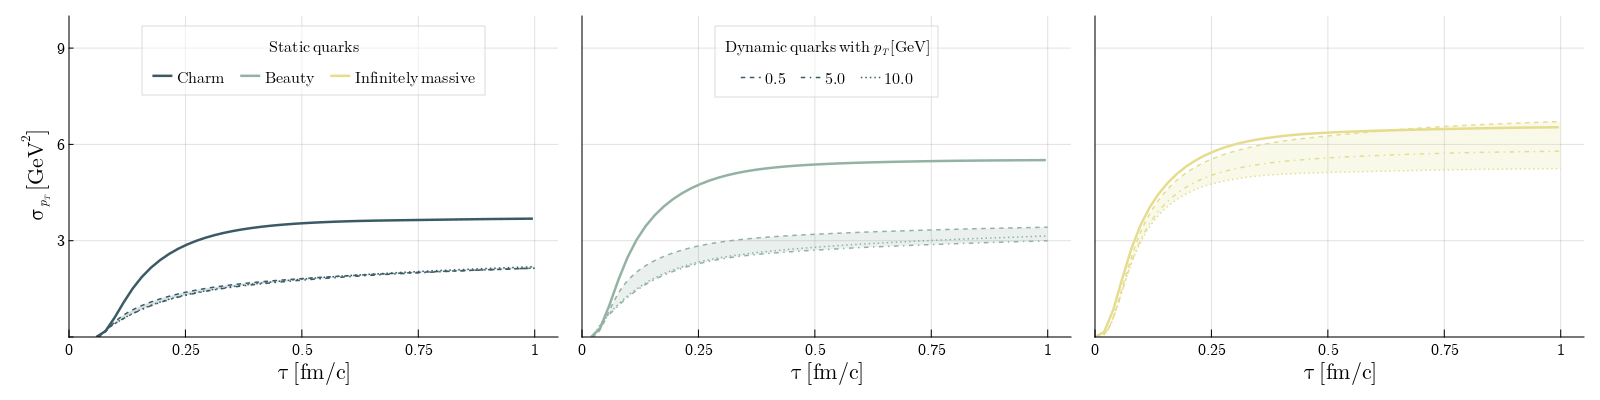

In [3]:
using CairoMakie
using ColorSchemes

redblue = cgrad(:starrynight, 11, categorical = true)
colors = [redblue[3], redblue[6], redblue[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (1600, 400), font = "CMU Serif")
axes = [Axis(fig[1, i], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\sigma_{p_T}\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) 
     for i in 1:3]

i = 1
for iq in 1:length(quarks)
    for ipT in 1:length(pTs)
        tag_sigmapt = quarks[iq] * "_pT_" * pTs[ipT]
        string_as_varname("linepT"*string(i), lines!(axes[iq], tau_sigmapt[tag_sigmapt], sigmapt[tag_sigmapt], linewidth = 1.5, color=colors[iq], linestyle=linestyles[ipT]))
        i = i+1

        next_tag_sigmapt = quarks[iq] * "_pT_" * pTs[mod(ipT+1, 3)+1]
        band!(axes[iq], tau_sigmapt[tag_sigmapt], sigmapt[tag_sigmapt], sigmapt[next_tag_sigmapt]; color = (colors[iq], 0.1))
    end
    tag_kappapt = quarks[iq]
    string_as_varname("lineq"*string(iq), lines!(axes[iq], Float64.(tau_kappapt[tag_kappapt]), kappapt[tag_kappapt], linewidth = 2.5, color=colors[iq]))

    ylims!(axes[iq], 0, 10)
    xlims!(axes[iq], 0, 1.05)
    axes[iq].xticks = (0.25*(0:4), ["0", "0.25", "0.5", "0.75", "1"])
    axes[iq].yticks = (3*(0:3), ["", "3", "6", "9"])
end

linkaxes!(axes[1], axes[2], axes[3])
hideydecorations!(axes[2], grid = false)
hideydecorations!(axes[3], grid = false)
legendq = [L"\mathrm{Charm}", L"\mathrm{Beauty}", L"\mathrm{Infinitely\,massive}"]
axislegend(axes[1], [lineq1, lineq2, lineq3], legendq, L"\mathrm{Static\,quarks}", 
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.5), framecolor=(:grey80, 0.7))
legendpT = [L"0.5", L"5.0", L"10.0"]
axislegend(axes[2], [linepT1, linepT2, linepT3], legendpT, L"\mathrm{Dynamic\,quarks\,with\,}p_T\,\mathrm{[GeV]}", 
    position = :ct, orientation = :horizontal, bgcolor = (:white, 0.5), framecolor=(:grey80, 0.7))

display(fig)
# save("sigmapt_kappa.png", fig, px_per_unit = 5.0) 

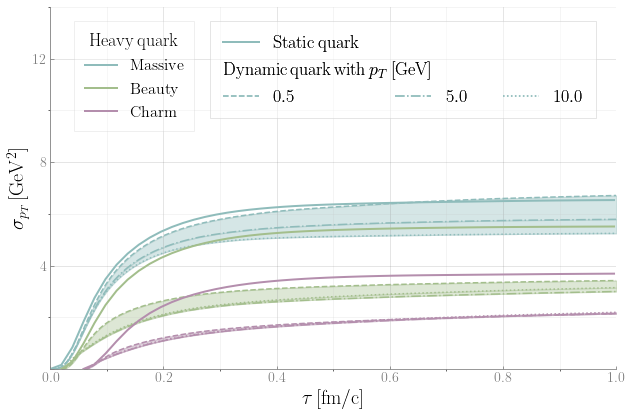

In [7]:
import pickle

sigmapt_data = pickle.load(open('sigmapt.pickle', 'rb'))
kappapt_data = pickle.load(open('kappapt.pickle', 'rb'))

sigmapt, tau_sigmapt = sigmapt_data['sigmapt'], sigmapt_data['tau']
kappapt, tau_kappa = kappapt_data['kappapt'], kappapt_data['tau']

quarks = ['static', 'beauty', 'charm']
pTs = [0.5, 5.0, 10.0]

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 20)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 20)

fig.patch.set_facecolor('white')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
ax.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.grid(b=True, which='minor', color='silver', alpha=0.2)

linestyles = ['--', '-.', ':']
colors = ['#8FBCBB', '#A3BE8C', '#B48EAD']
labels_quarks = [r'$\mathrm{Massive}$', r'$\mathrm{Beauty}$', r'$\mathrm{Charm}$']
labels_pTs = [r'$0.5$', r'$5.0$', r'$10.0$']

iq = 0
for quark in quarks:
    tag_kappa = quark
    ipT = 0
    for pT in pTs:
        tag = quark + '_pT_' + str(pT)
        ax.plot(tau_sigmapt[tag], sigmapt[tag], color=colors[iq], linewidth = 1.5, linestyle=linestyles[ipT])
        ipT += 1
    for i in range(3):
        for j in range(3):
            taglow, taghigh = quark + '_pT_' + str(pTs[i]), quark + '_pT_' + str(pTs[j])
            ax.fill_between(tau_sigmapt[taglow], sigmapt[taglow], sigmapt[taghigh], color=colors[iq], alpha=0.1)
    ax.plot(tau_kappa[tag_kappa], kappapt[tag_kappa], color=colors[iq], linewidth = 2)
    iq += 1

lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in [3,7,11]], labels_quarks, loc = 'upper right', ncol=1, bbox_to_anchor=(0.26,0.97), title=r'$\mathrm{Heavy\,quark}$', fontsize='16')
legend2.get_frame().set_boxstyle('square')
legend2.get_title().set_fontsize('18')
legend2.get_frame().set_alpha(0.3)
ax.add_artist(legend2)

import matplotlib.text as mtext
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

legend3 = plt.legend([lines[3], r'$\mathrm{Dynamic\,quark\,with\,}p_T\,\mathrm{[GeV]}$', lines[0], '', '', lines[1], '', '', lines[2]], [r'$\mathrm{Static\,quark}$', '', r'$0.5$', '', '', r'$5.0$', '', '',r'$10.0$'], handler_map={str: LegendTitle({'fontsize': 18})}, fontsize='18', loc = 'upper right', ncol=3, bbox_to_anchor=(0.97,0.97))
ax.add_artist(legend3)
legend3.get_frame().set_boxstyle('square')
legend3.get_title().set_fontsize('18')
legend3.get_frame().set_alpha(0.3)

ax.set_xlim(0, 1.0)
ax.set_ylim(0, 14)
ax.yaxis.set_major_locator(MultipleLocator(4))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)

plt.tight_layout()
# plt.savefig('sigmapt_kappa_' + su_group + '_comp.png', dpi=300, facecolor='white', transparent=False)